**General Description**

The following notebook contains the code to create, train, validate, and test a rainfall-runoff model using the LSTM-MDN network architecture. The notebook support running experiments in different large-sample hydrology datasets including: CAMELS-GB, CAMELS-US, CAMELS-DE. The details for each dataset can be read from a .yml file.

***Authors:***
- Manuel Alvarez Chaves (manuel.alvarez-chaves@simtech.uni-stuttgart.de)

In [1]:
import datetime
import pickle
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import xarray as xr
from hy2dl.datasetzoo import get_dataset
from hy2dl.modelzoo import get_model
from hy2dl.training.loss import loss_nll
from hy2dl.utils.config import Config
from hy2dl.utils.optimizer import Optimizer
from hy2dl.utils.utils import set_random_seed, upload_to_device
from torch.utils.data import DataLoader
from tqdm import tqdm

# colorblind friendly palette
color_palette = {"observed": "#377eb8","simulated": "#4daf4a"}

Part 1. Initialize information

In [2]:
# Path to .yml file where the experiment settings are stored. The experimet settings can also be defined manually as a dictionary.
path_experiment_settings = "../examples/mdn.yml"

# Read experiment settings
config = Config(path_experiment_settings)
config.init_experiment()
config.dump()

Folder '../results/LSTMCMAL-250-03_seed_42' was created to store the results.


Part 2. Create datasets and dataloaders used to train/validate the model

In [3]:
# Get dataset class
Dataset = get_dataset(config)

# Dataset training
config.logger.info(f"Loading training data from {config.dataset} dataset")
total_time = time.time()

training_dataset = Dataset(cfg=config, 
                           time_period="training")

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(save_scaler=True)
training_dataset.standardize_data()

config.logger.info(f"Number of entities with valid samples: {len(training_dataset.df_ts)}")
config.logger.info(f"Time required to process {len(training_dataset.df_ts)} entities: {datetime.timedelta(seconds=int(time.time()-total_time))}")
config.logger.info(f"Number of valid training samples: {len(training_dataset)}\n")

# Dataloader training
train_loader = DataLoader(dataset=training_dataset,
                          batch_size=config.batch_size_training,
                          shuffle=True,
                          drop_last=True,
                          collate_fn=training_dataset.collate_fn,
                          num_workers=config.num_workers)

# Print details of a loader´s sample to check that the format is correct
config.logger.info("Details training dataloader".center(60, "-"))
config.logger.info(f"Batch structure (number of batches: {len(train_loader)})")
config.logger.info(f"{'Key':^30}|{'Shape':^30}")

# Loop through the sample dictionary and print the shape of each element
for key, value in next(iter(train_loader)).items():
    if key.startswith(("x_d", "x_conceptual")):
        config.logger.info(f"{key}")
        for i, v in value.items():
            config.logger.info(f"{i:^30}|{str(v.shape):^30}")
    else:
        config.logger.info(f"{key:<30}|{str(value.shape):^30}")
        
config.logger.info("")  # prints a blank line

2025-11-07 10:43:07 - Loading training data from camels_us dataset


Processing entities: 100%|##########| 531/531 [01:07<00:00,  7.86entity/s]


2025-11-07 10:44:15 - Number of entities with valid samples: 531
2025-11-07 10:44:15 - Time required to process 531 entities: 0:01:08
2025-11-07 10:44:15 - Number of valid training samples: 1745928

2025-11-07 10:44:15 - ----------------Details training dataloader-----------------
2025-11-07 10:44:15 - Batch structure (number of batches: 6820)
2025-11-07 10:44:15 -              Key              |            Shape             
2025-11-07 10:44:16 - x_d
2025-11-07 10:44:16 -      prcp(mm/day)_daymet      |    torch.Size([256, 365])    
2025-11-07 10:44:16 -       PRCP(mm/day)_nldas      |    torch.Size([256, 365])    
2025-11-07 10:44:16 -      PRCP(mm/day)_maurer      |    torch.Size([256, 365])    
2025-11-07 10:44:16 -       srad(W/m2)_daymet       |    torch.Size([256, 365])    
2025-11-07 10:44:16 -         tmax(C)_daymet        |    torch.Size([256, 365])    
2025-11-07 10:44:16 -         tmin(C)_daymet        |    torch.Size([256, 365])    
2025-11-07 10:44:16 -         vp(Pa)_day

In [4]:
config.logger.info(f"Loading validation data from {config.dataset} dataset")

# Validate on random basins
if config.validate_n_random_basins > 0:
    entities_ids = np.loadtxt(config.path_entities, dtype="str").tolist()
    random_basins = np.random.choice(entities_ids, size=config.validate_n_random_basins, replace=False).tolist()

total_time = time.time()
validation_dataset = Dataset(cfg=config,
                      time_period="validation",
                      entities_ids=random_basins if config.validate_n_random_basins > 0 else None)
    
validation_dataset.scaler = training_dataset.scaler
validation_dataset.standardize_data()

config.logger.info(f"Time required to process {len(validation_dataset.df_ts)} entities: {datetime.timedelta(seconds=int(time.time()-total_time))}\n")
config.logger.info(f"Number of validation samples: {len(validation_dataset)}\n")

validation_loader = DataLoader(dataset=validation_dataset,
                                  batch_size=config.batch_size_evaluation,
                                  shuffle=False,
                                  drop_last=False,
                                  collate_fn=validation_dataset.collate_fn,
                                  num_workers=config.num_workers)

2025-11-07 10:44:16 - Loading validation data from camels_us dataset


Processing entities: 100%|##########| 531/531 [01:07<00:00,  7.87entity/s]


2025-11-07 10:45:23 - Basins without valid samples in period of interest: ['02427250', '09484600']
2025-11-07 10:45:23 - Time required to process 529 entities: 0:01:07

2025-11-07 10:45:23 - Number of validation samples: 1606135



In [5]:
# Initialize model
set_random_seed(cfg=config)
model = get_model(config).to(config.device)

Part 3. Train model

In [6]:
# Initialize model
set_random_seed(cfg=config)
model = get_model(config).to(config.device)

# Initialize optimizer
optimizer = Optimizer(cfg=config, model=model) 

# Training report structure
config.logger.info("Training model".center(60, "-"))
config.logger.info(f"{'':^16}|{'Trainining':^21}|{'Validation':^21}|")
config.logger.info(f"{'Epoch':^5}|{'LR':^10}|{'Loss':^10}|{'Time':^10}|{'Metric':^10}|{'Time':^10}|")

total_time = time.time()
# Loop through epochs
for epoch in range(1, config.epochs + 1):
    train_time = time.time()
    loss_evol = []
    # Training -------------------------------------------------------------------------------------------------------
    model.train()
    # Loop through the different batches in the training dataset
    iterator = tqdm(train_loader, 
                    desc=f"Epoch {epoch}/{config.epochs}. Training", 
                    unit="batches", 
                    ascii=True, 
                    leave=False)
    
    for idx, sample in enumerate(iterator):
        # reach maximum iterations per epoch
        if config.max_updates_per_epoch is not None and idx >= config.max_updates_per_epoch:
            break

        # Add noise to input and output variables
        noise = 0.10
        for k, v in sample.items():
            if k.startswith("x_d"):
                for ik, iv in v.items():
                    sample[k][ik] = iv + iv * torch.randn_like(iv) * noise
            if k.startswith("y_obs"):
                sample[k] = v + v * torch.randn_like(v) * noise

        # Continue with training
        sample = upload_to_device(sample, config.device)  # upload tensors to device
        optimizer.optimizer.zero_grad()  # sets gradients to zero
        
        # Forward pass of the model
        pred = model(sample)
        loss = loss_nll(
            params=pred["params"],
            weights=pred["weights"],
            dist=model.distribution,
            y_obs=sample["y_obs"]
        )
        loss = loss.sum()
        
        # Backpropagation (calculate gradients)
        loss.backward()
        
        # Update model parameters (e.g, weights and biases)
        optimizer.clip_grad_and_step(epoch, idx)

        # Keep track of the loss per batch
        loss_evol.append(loss.item())
        iterator.set_postfix({"loss": f"{np.mean(loss_evol):.3f}"})

        # remove elements from cuda to free memory
        del sample, pred
        torch.cuda.empty_cache()

    # training report
    report = f'{epoch:^5}|{optimizer.optimizer.param_groups[0]["lr"]:^10.5f}|{np.mean(loss_evol):^10.3f}|{str(datetime.timedelta(seconds=int(time.time()-train_time))):^10}|'

    # Validation -----------------------------------------------------------------------------------------------------
    if epoch % config.validate_every == 0:
        val_time = time.time()
        model.eval()

        iterator = tqdm(validation_loader, 
                desc=f"Epoch {epoch}/{config.epochs}. Validation", 
                unit="batches", 
                ascii=True, 
                leave=False)
        
        with torch.no_grad():
            loss_evol = []
            for idx, sample in enumerate(iterator):
                sample = upload_to_device(sample, config.device)
                pred = model(sample)
                loss = loss_nll(
                    params=pred["params"],
                    weights=pred["weights"],
                    dist=model.distribution,
                    y_obs=sample["y_obs"]
                )
                loss = loss.sum()
                loss_evol.append(loss.item())
                iterator.set_postfix({"loss": f"{np.nanmean(loss_evol):.3f}"})

            # average loss validation
            report += f"{np.nanmean(loss_evol):^10.3f}|{str(datetime.timedelta(seconds=int(time.time()-val_time))):^10}|"

    # No validation
    else:
        report += f"{'':^10}|{'':^10}|"
    

    # Print report and save model
    config.logger.info(report)
    torch.save(model.state_dict(), config.path_save_folder / "model" / f"model_epoch_{epoch}")
    # modify learning rate
    optimizer.update_optimizer_lr(epoch=epoch)

# print total training time
config.logger.info(f'Total training time: {datetime.timedelta(seconds=int(time.time()-total_time))}\n')

2025-11-07 10:45:25 - -----------------------Training model-----------------------
2025-11-07 10:45:25 -                 |     Trainining      |     Validation      |
2025-11-07 10:45:25 - Epoch|    LR    |   Loss   |   Time   |  Metric  |   Time   |


2025-11-07 10:53:52 -   1  | 0.00050  |  -0.844  | 0:07:06  |  -1.135  | 0:01:20  |


2025-11-07 11:02:13 -   2  | 0.00050  |  -1.056  | 0:07:06  |  -1.176  | 0:01:15  |


2025-11-07 11:10:34 -   3  | 0.00050  |  -1.120  | 0:07:04  |  -1.190  | 0:01:16  |


2025-11-07 11:18:50 -   4  | 0.00050  |  -1.160  | 0:06:59  |  -1.229  | 0:01:16  |


2025-11-07 11:27:06 -   5  | 0.00050  |  -1.189  | 0:07:01  |  -1.175  | 0:01:14  |
2025-11-07 11:27:06 - Total training time: 0:41:41



Part 4. Test model

In [7]:
# In case I already trained an LSTM I can re-construct the model. I just need to define the epoch for which I want to
# re-construct the model
# model = get_model(config).to(config.device)
model.load_state_dict(torch.load(config.path_save_folder / "model" / "model_epoch_4", map_location=config.device))

<All keys matched successfully>

In [8]:
# Read previously generated scaler
with open(config.path_save_folder / "scaler.pickle", "rb") as file:
    scaler = pickle.load(file)

# Helper function to backtransform
def backtransform(y, scaler=scaler):
    mean, std = scaler["y_mean"].to(config.device), scaler["y_std"].to(config.device)
    return y * std + mean

In [9]:
# In evaluation (validation and testing) we will create an individual dataset per basin
config.logger.info(f"Loading testing data from {config.dataset} dataset")

# entities_ids = np.loadtxt(config.path_entities_testing, dtype="str").tolist()
path_entities_ids = "../data/basin_id/basins_camels_us_10.txt"
entities_ids = np.loadtxt(path_entities_ids, dtype="str").tolist()

iterator = tqdm([entities_ids] if isinstance(entities_ids, str) else entities_ids, 
                desc="Processing entities", 
                unit="entity", 
                ascii=True)

total_time = time.time()
testing_dataset = {}
for entity in iterator:
    dataset = Dataset(cfg= config, 
                      time_period= "testing",
                      check_NaN=False,
                      entities_ids=entity)

    dataset.scaler = scaler
    dataset.standardize_data(standardize_output=False)
    testing_dataset[entity] = dataset

config.logger.info(f"Time required to process {len(iterator)} entities: {datetime.timedelta(seconds=int(time.time()-total_time))}\n")

2025-11-07 11:27:49 - Loading testing data from camels_us dataset


Processing entities: 100%|##########| 10/10 [00:01<00:00,  6.32entity/s]

2025-11-07 11:27:50 - Time required to process 10 entities: 0:00:01



For testing, I find it better to simply get the results I want from the model and save them as a netCDF. That way, I don't have to run the model every time I want a prediction at the cost of knowing in hindsight everything that I will need. Everything comes with a trade-off.

In this example, for every day I generate:
* distribution parameters
* distribution weights
* prediction:
    * mean
    * quantiles
    * samples

And then save these outputs as a netCDF file.

**Note**: This is very slow mainly due to the `quantile` method which uses Newton iterations.

In [10]:
config.logger.info("Testing model".center(60, "-"))
total_time = time.time()

model.eval()
out = {}
with torch.no_grad():
    # Go through each basin
    iterator = tqdm(testing_dataset, desc=f"Testing", unit="basins", ascii=True)
    for basin in iterator:
        loader = DataLoader(
            dataset=testing_dataset[basin],
            batch_size=config.batch_size_evaluation,
            shuffle=False,
            drop_last=False,
            collate_fn=testing_dataset[basin].collate_fn,
            num_workers=config.num_workers
        )

        dates, y_obs, y_hat, params, weights = [], [], {"mean": [], "quantile": [], "samples": []}, {}, []
        for sample in loader:
            sample = upload_to_device(sample, config.device)  # upload tensors to device

            dates.append(sample["date"])
            y_obs.append(sample["y_obs"].detach().cpu().numpy())

            # Save the parameters of the predictive distribution
            batch_params, batch_weights = model(sample).values()
            for k, v in batch_params.items():
                params[k] = params.get(k, []) + [v.detach().cpu().numpy()]

            weights.append(batch_weights.detach().cpu().numpy())
            
            # Generate predictions
            # 1. Mean
            mean = backtransform(model.mean(sample))
            y_hat["mean"].append(mean.detach().cpu().numpy())

            # 2. Quantiles
            quantile = backtransform(model.quantile(sample, [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]))
            y_hat["quantile"].append(quantile.detach().cpu().numpy())

            # 3. Sampling
            samples = backtransform(model.sample(sample, 1000))
            y_hat["samples"].append(samples.detach().cpu().numpy())

            # remove from cuda
            del sample, batch_params, batch_weights, samples, mean, quantile
            torch.cuda.empty_cache()

        out[basin] = {
            "date": np.concatenate(dates),
            "y_obs": np.concatenate(y_obs),
            "y_hat": {k: np.concatenate(v) for k, v in y_hat.items()},
            "params": {k: np.concatenate(v) for k, v in params.items()},
            "weights": np.concatenate(weights)
        }
        del dates, y_obs, y_hat, params, weights


config.logger.info(f'Total testing time: {datetime.timedelta(seconds=int(time.time()-total_time))}')

2025-11-07 11:27:53 - -----------------------Testing model------------------------


Testing: 100%|##########| 10/10 [02:42<00:00, 16.28s/basins]

2025-11-07 11:30:36 - Total testing time: 0:02:42


In [11]:
def to_xarray(out_dict):
    # Get all basin IDs
    basin_ids = list(out_dict.keys())
   
    # Get dates from first basin (assuming all basins have same dates)
    dates = out_dict[basin_ids[0]]['date']
    num_days = dates.shape[0]
   
    # Get dimensions from the first basin
    first_basin = out_dict[basin_ids[0]]
    num_basins = len(basin_ids)
    predict_last_n = first_basin['y_obs'].shape[1]
    num_targets = first_basin['y_obs'].shape[2]
    
    # Get dimensions for different y_hat types
    num_samples = first_basin['y_hat']['samples'].shape[2]  # from samples
    num_quantiles = first_basin['y_hat']['quantile'].shape[2]  # from quantiles
   
    # Get parameter names dynamically from params subdictionary
    param_names = list(first_basin['params'].keys())
    num_components = first_basin['params'][param_names[0]].shape[2]
   
    # Initialize arrays for fixed variables
    y_obs_array = np.zeros((num_basins, num_days, predict_last_n, num_targets))
    y_hat_mean_array = np.zeros((num_basins, num_days, predict_last_n, num_targets))
    y_hat_quantile_array = np.zeros((num_basins, num_days, predict_last_n, num_quantiles, num_targets))
    y_hat_samples_array = np.zeros((num_basins, num_days, predict_last_n, num_samples, num_targets))
    weights_array = np.zeros((num_basins, num_days, predict_last_n, num_components, num_targets))
   
    # Initialize arrays for parameter variables dynamically
    param_arrays = {}
    for param_name in param_names:
        param_arrays[param_name] = np.zeros((num_basins, num_days, predict_last_n, num_components, num_targets))
   
    # Fill arrays
    for idx, basin_id in enumerate(basin_ids):
        basin_data = out_dict[basin_id]
        y_obs_array[idx] = basin_data['y_obs']
        y_hat_mean_array[idx] = basin_data['y_hat']['mean']
        y_hat_quantile_array[idx] = basin_data['y_hat']['quantile']
        y_hat_samples_array[idx] = basin_data['y_hat']['samples']
        weights_array[idx] = basin_data['weights']
       
        # Fill parameter arrays dynamically
        for param_name in param_names:
            param_arrays[param_name][idx] = basin_data['params'][param_name]
    
    # Create coordinate arrays
    coords = {
        'basin_id': basin_ids,
        'date': dates[:, -1],
        'predict_last_n': np.arange(predict_last_n),
        'num_targets': np.arange(num_targets),
        'num_samples': np.arange(num_samples),
        'num_quantiles': np.arange(num_quantiles),
        'num_components': np.arange(num_components)
    }
   
    # Create data variables
    data_vars = {
        'y_obs': (['basin_id', 'date', 'predict_last_n', 'num_targets'], y_obs_array),
        'y_hat_mean': (['basin_id', 'date', 'predict_last_n', 'num_targets'], y_hat_mean_array),
        'y_hat_quantile': (['basin_id', 'date', 'predict_last_n', 'num_quantiles', 'num_targets'], y_hat_quantile_array),
        'y_hat_samples': (['basin_id', 'date', 'predict_last_n', 'num_samples', 'num_targets'], y_hat_samples_array),
        'weights': (['basin_id', 'date', 'predict_last_n', 'num_components', 'num_targets'], weights_array)
    }
   
    # Add parameter variables dynamically
    for param_name in param_names:
        data_vars[param_name] = (['basin_id', 'date', 'predict_last_n', 'num_components', 'num_targets'], param_arrays[param_name])
   
    # Create the dataset
    ds = xr.Dataset(data_vars, coords=coords)
   
    # Add attributes for better documentation
    ds.attrs['description'] = 'Basin prediction data with observations, predictions, and model parameters'
    ds['y_obs'].attrs['description'] = 'Observed values'
    ds['y_hat_mean'].attrs['description'] = 'Predicted mean values'
    ds['y_hat_quantile'].attrs['description'] = 'Predicted quantile values [0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975]'
    ds['y_hat_samples'].attrs['description'] = 'Predicted sample values (ensemble samples)'
    ds['weights'].attrs['description'] = 'Weight values'
   
    # Add parameter descriptions dynamically
    for param_name in param_names:
        ds[param_name].attrs['description'] = f'{param_name.capitalize()} parameters'
   
    return ds

ds = to_xarray(out)
path_experiment = config.path_save_folder / f"rest_results.nc"
compression = {var: {"zlib":True, "complevel":5, "dtype":"f4"} for var in ds.data_vars}
ds.to_netcdf(path_experiment, encoding=compression)

Part 5. Initial analysis

In [12]:
ds = xr.open_dataset(config.path_save_folder / "rest_results.nc")

In [13]:
# Select data
basin_to_analyze = "13011900"
data = ds.sel(basin_id=basin_to_analyze).sel(date=slice("1991-02-20", "1991-11-15"))

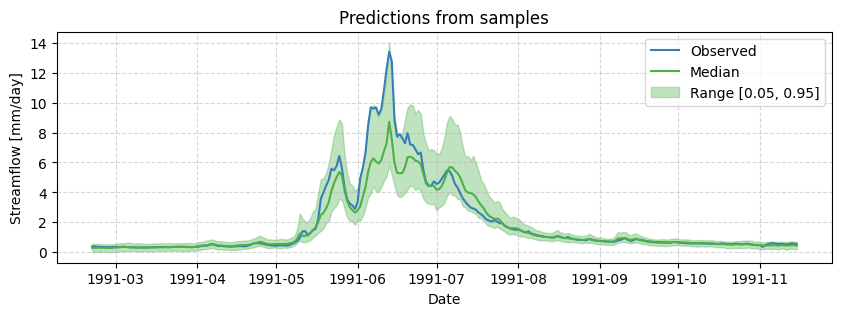

In [14]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(data["date"], data["y_obs"][:, 0, 0], label="Observed", color=color_palette["observed"])
ax.plot(data["date"], data["y_hat_samples"].median(dim="num_samples")[:, 0, 0], label="Median", color=color_palette["simulated"])
ax.fill_between(data["date"], data["y_hat_samples"].quantile(0.05, dim="num_samples")[:, 0, 0], data["y_hat_samples"].quantile(0.95, dim="num_samples")[:, 0, 0], color=color_palette["simulated"], alpha=0.35, label="Range [0.05, 0.95]")
ax.grid(ls="--", alpha=0.5)

# Format plot
ax.legend()
ax.set_ylabel("Streamflow [mm/day]")
ax.set_xlabel("Date")
ax.set_title("Predictions from samples")
plt.show()

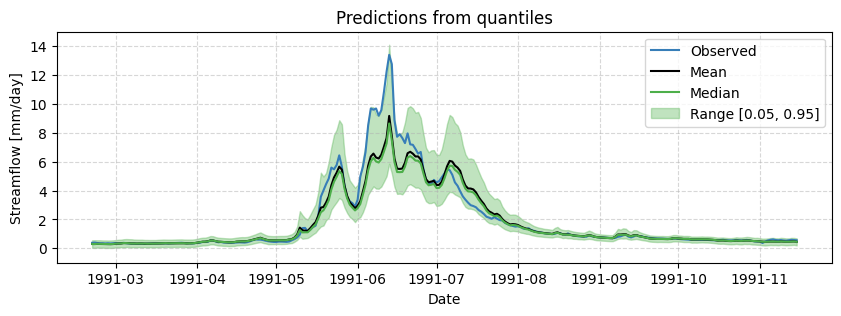

In [15]:
fig, ax = plt.subplots(figsize=(10, 3))

ax.plot(data["date"], data["y_obs"][:, 0, 0], label="Observed", color=color_palette["observed"])
ax.plot(data["date"], data["y_hat_mean"][:, 0, 0], label="Mean", color="k")
ax.plot(data["date"], data["y_hat_quantile"][:, 0, 3], label="Median", color=color_palette["simulated"])
ax.fill_between(data["date"], data["y_hat_quantile"][:, 0, 1, 0], data["y_hat_quantile"][:, 0, 5, 0], color=color_palette["simulated"], alpha=0.35, label="Range [0.05, 0.95]")
ax.grid(ls="--", alpha=0.5)

# Format plot
ax.legend()
ax.set_ylabel("Streamflow [mm/day]")
ax.set_xlabel("Date")
ax.set_title("Predictions from quantiles")
ax.set_ylim(-1, 15)
plt.show()

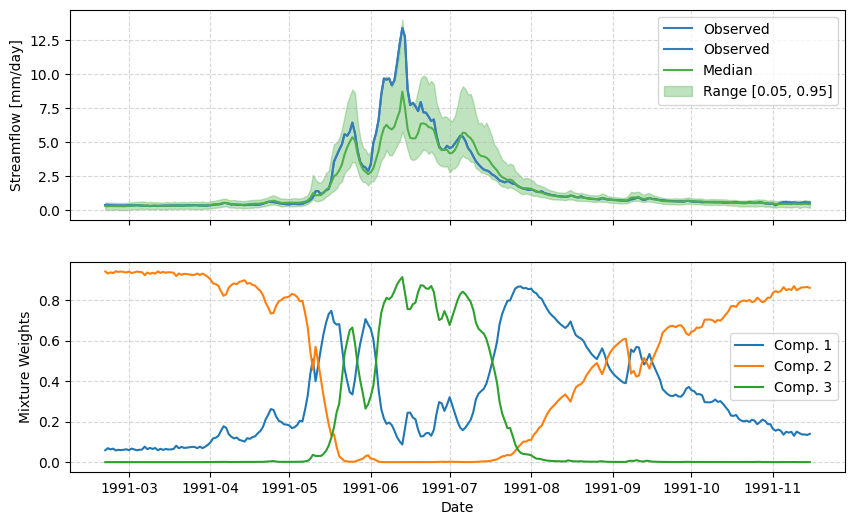

In [16]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 6), sharex=True)
axes[0].plot(data["date"], data["y_obs"][:, 0, 0], label="Observed", color=color_palette["observed"])
axes[0].plot(data["date"], data["y_obs"][:, 0, 0], label="Observed", color=color_palette["observed"])
axes[0].plot(data["date"], data["y_hat_samples"].median(dim="num_samples")[:, 0, 0], label="Median", color=color_palette["simulated"])
axes[0].fill_between(data["date"], data["y_hat_samples"].quantile(0.05, dim="num_samples")[:, 0, 0], data["y_hat_samples"].quantile(0.95, dim="num_samples")[:, 0, 0], color=color_palette["simulated"], alpha=0.35, label="Range [0.05, 0.95]")
axes[0].set_ylabel("Streamflow [mm/day]")

axes[1].plot(data["date"], data["weights"][:, 0, :, 0], label=[f"Comp. {i+1}" for i in range(data["weights"].shape[2])])
axes[1].set_ylabel("Mixture Weights")
axes[1].set_xlabel("Date")

# Format plot
for ax in axes:
    ax.grid(ls="--", alpha=0.5)
    ax.legend()

plt.show()